# Прогнозирование поведения клиента (ДЗ)

1) Построить кривые DEF rate и DLQ ratio, используя PD, полученный на предыдущем ДЗ. В качестве результаты приложите отдельный ноутбук с названием 'Surname_def_dlq.ipynb' (1 балл)

#### Импортируем нужные библиотеки

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive

from scipy.optimize import minimize
from sklearn.metrics import r2_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#### Выгружаем данные с винтажами

In [2]:
#можно сразу написать 
#df = pd.read_csv('df_scores_and_vintages.csv')
#далее показываются преобразования данных data_scores_and_features.csv, предсказание pd на них

In [4]:
df1 = pd.read_csv('data_vintages1.csv')
df2 = pd.read_csv('data_vintages2.csv')

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
df = pd.concat([df1, df2])

In [6]:
df.isna().sum()

user_id           1
statement_num     0
gen_month_dt      0
gen_quarter_dt    0
clo_flg           0
def_flg           0
dlq_flg           0
act_flg           0
prev_clo_flg      0
prev_def_flg      1
prev_dlq_flg      1
prev_act_flg      2
dtype: int64

In [7]:
df = df.dropna().drop_duplicates(keep = 'first', subset = ['user_id', 'statement_num'])

In [8]:
df['user_id'] = df['user_id'].astype(int)

In [9]:
df['statement_num'] = df['statement_num'].astype(int)

#### Подготавливаем данные и предсказываем PD на заданной выборке (можно пропустить, так как в конце есть уже полученный df_scores)

In [11]:
# Тебе понадобятся два скора: 
# 1) x_score из файла data_scores.csv 
# 2) PD (вероятность дефолта за 12 месяцев), который вы получили в предыдущем ДЗ

df_scores_and_features = pd.read_csv('data_scores_and_features.csv',
    encoding="cp1251",
    decimal=',',
)
df_scores_and_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104820 entries, 0 to 104819
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   user_id                  104820 non-null  int64  
 1   pd                       104820 non-null  float64
 2   x_score                  104820 non-null  float64
 3   max_util                 104817 non-null  object 
 4   avg_util                 104817 non-null  object 
 5   credits_2y               104817 non-null  object 
 6   credits_4y               104817 non-null  object 
 7   bad_history_credits_flg  104820 non-null  int64  
 8   other_util               104817 non-null  object 
 9   avg_term                 104807 non-null  object 
 10  min_term                 104807 non-null  object 
 11  avg_limit_mortgage       104817 non-null  object 
 12  min_limit_mfo            104817 non-null  object 
 13  close_balance_amt        104817 non-null  object 
 14  soc_

In [12]:
features = ['max_util', 'avg_util', 'credits_2y',
       'credits_4y', 'bad_history_credits_flg', 'other_util', 'avg_term',
       'min_term', 'avg_limit_mortgage', 'min_limit_mfo',
       'close_balance_amt', 'soc_dem_score', 'max_delq_cnt',
       'avg_active_time', 'last_credit_time_years']
df_scores_and_features[features] = df_scores_and_features[features].astype(float)

In [13]:
df_scores_and_features[df_scores_and_features.duplicated()].head() #дубликатов нет

,user_id,pd,x_score,max_util,avg_util,credits_2y,credits_4y,bad_history_credits_flg,other_util,avg_term,min_term,avg_limit_mortgage,min_limit_mfo,close_balance_amt,soc_dem_score,max_delq_cnt,avg_active_time,last_credit_time_years


In [14]:
df_scores_and_features[df_scores_and_features['max_util'].isna()] # удаляем этих клиентов, так как у них много пропусков
df_scores_and_features = df_scores_and_features[df_scores_and_features['max_util'].notna()] # удаляем трех клиентов с пропусками

In [15]:
df_scores_and_features[features].describe()

,max_util,avg_util,credits_2y,credits_4y,bad_history_credits_flg,other_util,avg_term,min_term,avg_limit_mortgage,min_limit_mfo,close_balance_amt,soc_dem_score,max_delq_cnt,avg_active_time,last_credit_time_years
count,104817.000000,104817.000000,104817.000000,104817.000000,104817.000000,104817.000000,104807.000000,104807.000000,1.048170e+05,1.048170e+05,1.048170e+05,104817.000000,104817.000000,98987.000000,104817.000000
mean,1.216355,0.273270,0.306744,0.470849,0.868628,0.316879,93.642094,-15.491618,5.517559e+05,7.562125e+03,1.006994e+06,-6.303943,0.041320,136.056169,1.027572
std,10.287488,1.207077,0.583309,0.730423,0.337808,0.171945,130.143293,68.349712,1.414406e+06,8.240922e+04,3.537040e+06,1.733048,0.501429,470.695906,1.809981
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.161598,-360.214286,-1452.000000,-1.000000e+00,-1.000000e+00,0.000000e+00,-13.980132,0.000000,-173.000000,0.000000
25%,0.635200,0.087238,0.000000,0.000000,1.000000,0.217163,15.857143,-39.000000,-1.000000e+00,-1.000000e+00,1.189690e+05,-7.464291,0.000000,12.000000,0.000000
50%,0.928828,0.182271,0.000000,0.000000,1.000000,0.252247,49.500000,-7.000000,-1.000000e+00,-1.000000e+00,4.024327e+05,-6.289372,0.000000,48.000000,1.000000
75%,0.994615,0.322217,1.000000,1.000000,1.000000,0.335923,132.000000,1.000000,-1.000000e+00,-1.000000e+00,1.033237e+06,-5.129984,0.000000,117.000000,1.000000
max,1821.747200,205.623958,13.000000,14.000000,1.000000,1.000000,10167.333333,1130.000000,8.461661e+07,2.000000e+07,7.277486e+08,1.022012,31.000000,29524.000000,99.000000


In [16]:
out_features = ['max_util', 'avg_util', 'avg_term', 'min_term', 'last_credit_time_years'] # фичи, в которых есть выбросы

In [17]:
q98 = pd.Series([1.462465, 0.968241, 501.000000, 57.000000, 6.000000], index = out_features) # 98-квантили из обучающей выборке из предыдущего ДЗ
q98

max_util                    1.462465
avg_util                    0.968241
avg_term                  501.000000
min_term                   57.000000
last_credit_time_years      6.000000
dtype: float64

In [18]:
# лучшие признаки, отобранные из предыдущего ДЗ, которые получались при фильтрации по ROC AUC и коррелянтов
cor_and_auc_features = ['max_util',
 'credits_4y',
 'avg_term',
 'avg_limit_mortgage',
 'min_limit_mfo',
 'close_balance_amt',
 'soc_dem_score',
 'avg_active_time',
 'last_credit_time_years'] 

In [19]:
#делаем такую же предобработку данных
def preprocessing(df):

    # выкидываем верхние 2%(считаем перцентили от трейн выборки)
    for feature in out_features:
        df = df[df[feature] <= q98[feature]]
        
    # заполняем отрицательные значения и пропуски: avg_term и avg_active_time нулями, а min_term - медианой 1  
    df.loc[df['avg_term'] < 0, 'avg_term'] = np.nan
    df.loc[df['min_term'] < 0, 'min_term'] = np.nan
    df.loc[df['avg_active_time'] < 0, 'avg_active_time'] = np.nan
    df.fillna({'avg_term':0, 'min_term':1.0, 'avg_active_time':0.0}, inplace = True)
    
    # зануляем те -1, которые показывают, что у клиента нет данных
    df.replace(
        to_replace = {'avg_limit_mortgage': -1.0, 'min_limit_mfo': -1.0},
        value = {'avg_limit_mortgage': 0.0, 'min_limit_mfo': 0.0}, inplace = True)
    
    return df

In [20]:
df_scores_and_features = preprocessing(df_scores_and_features)

In [21]:
df_scores_and_features[cor_and_auc_features]

,max_util,credits_4y,avg_term,avg_limit_mortgage,min_limit_mfo,close_balance_amt,soc_dem_score,avg_active_time,last_credit_time_years
0,0.000000,0.0,0.000000,0.0,0.0,0.0,-5.834056,0.0,0.0
1,0.000000,0.0,190.714286,3545000.0,0.0,39646.0,-7.996644,170.0,0.0
2,0.906661,0.0,19.000000,0.0,0.0,9087.0,-4.420416,21.0,1.0
3,1.003618,1.0,138.500000,0.0,0.0,1262802.0,-6.395523,60.0,2.0
4,0.900334,0.0,8.200000,0.0,0.0,10801.0,-6.920208,16.0,2.0
...,...,...,...,...,...,...,...,...,...
104815,0.964679,1.0,9.750000,0.0,0.0,482463.0,-5.870624,23.0,3.0
104816,1.024933,1.0,194.200000,0.0,0.0,216829.0,-5.389767,14.0,0.0
104817,0.804570,0.0,5.900000,0.0,29400.0,1593051.0,-6.395103,45.0,1.0
104818,0.933907,0.0,37.857143,0.0,0.0,324267.0,-6.146846,114.0,1.0


In [22]:
#открываем сохраненную обученную модель
import pickle
filename = '/Users/armen/Desktop/Тинькофф Финтех/gbtd_model.sav'
model = pickle.load(open(filename, 'rb'))

In [23]:
pd_pred = model.predict_proba(df_scores_and_features[cor_and_auc_features])[:, 1]

In [24]:
#получаем данные probability of default, полученную на модели
df_scores_and_features['pd'] = pd_pred

In [25]:
df_scores = df_scores_and_features[['user_id', 'pd', 'x_score']]

In [26]:
df_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99609 entries, 0 to 104819
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  99609 non-null  int64  
 1   pd       99609 non-null  float64
 2   x_score  99609 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 3.0 MB


#### Бъем выборку на бакеты и джойним с данными с винтажами

In [27]:
df_scores = df_scores.sort_values(['pd'], ignore_index=True)
df_scores['pd_bucket'] = np.minimum(df_scores.index // (df_scores.shape[0]//3),2)
print(df_scores.groupby(['pd_bucket'])['pd'].mean())

df_scores = df_scores.sort_values(['x_score'], ignore_index=True)
df_scores['x_bucket'] = np.minimum(df_scores.index // (df_scores.shape[0]//3),2)
print(df_scores.groupby(['x_bucket'])['x_score'].mean())

df = df.merge(df_scores[['user_id', 'pd_bucket', 'x_bucket', 'pd', 'x_score']], how='left', on='user_id').dropna()
df.head()

pd_bucket
0    0.026682
1    0.050289
2    0.100542
Name: pd, dtype: float64
x_bucket
0    0.133218
1    0.221375
2    0.381116
Name: x_score, dtype: float64


,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg,pd_bucket,x_bucket,pd,x_score
0,127336,19,2019-07-01,2019-07-01,0,0,0,1,0,0.0,0.0,1.0,2.0,2.0,0.070855,0.469410
1,35907,16,2019-04-01,2019-04-01,1,0,0,0,1,0.0,0.0,0.0,1.0,0.0,0.056002,0.157215
2,45228,21,2019-05-01,2019-04-01,0,0,0,1,0,0.0,0.0,1.0,1.0,2.0,0.051887,0.469583
4,130780,19,2019-08-01,2019-07-01,1,0,0,0,1,0.0,0.0,0.0,1.0,1.0,0.048876,0.269492
5,13089,14,2019-03-01,2019-01-01,0,0,0,1,0,0.0,0.0,1.0,0.0,0.0,0.027215,0.160627


Сохраняем данные df_scores_and_vintages с винтажами и скорами, полученными из модели с прошлого домашнего задания

In [28]:
df.to_csv('df_scores_and_vintages.csv')

#### Выявим странные поколения

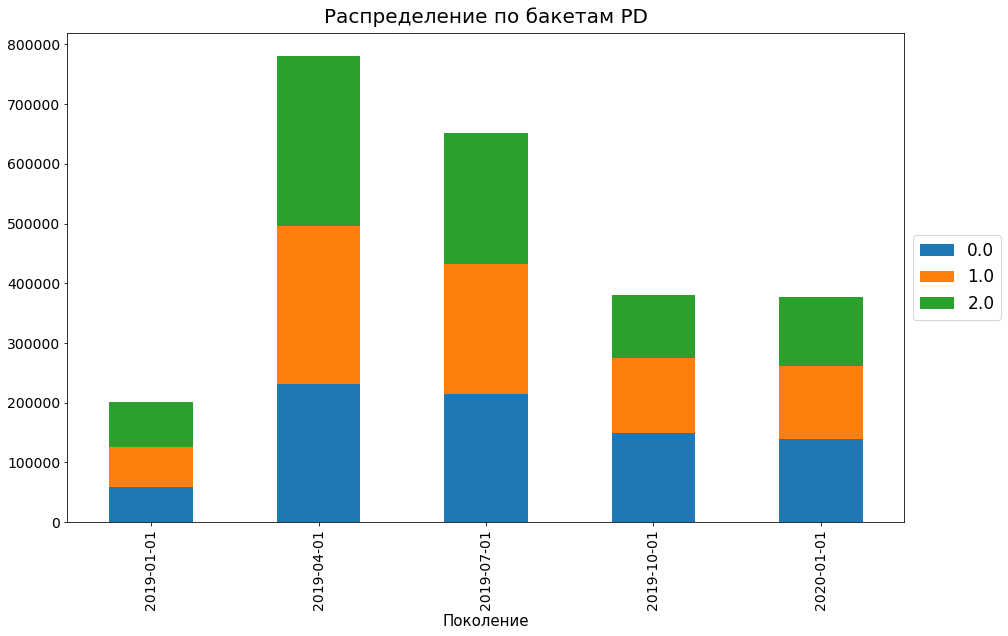

In [3]:
def plot_distribution(df, bucket):
    return pd.pivot_table(df, index=[bucket], columns='gen_quarter_dt',          # делаем сводную таблицу и транспонируем ее
                values="user_id",
                aggfunc=np.count_nonzero, fill_value=0)\
               .T\
               .plot(kind='bar', stacked=True, figsize=(15, 9))                    # Рисуем график распределения столбиками

plot_distribution(df, 'pd_bucket')

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Распределение по бакетам PD", size=20, verticalalignment='bottom')
plt.xlabel("Поколение", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

В 1 квартале 2019 года данных не так много, как в остальных, но достаточно для анализа. Никакие поколения и бакеты выбрасывать не будем.

In [4]:
%matplotlib inline
# Выгружаем таблицу c винтажами

default_rate_data = df.eval('def_new_flg = def_flg * prev_act_flg', inplace=False)\
    .groupby(["gen_quarter_dt", 'pd_bucket', "statement_num"])\
    .agg({"def_new_flg":np.sum, "prev_act_flg":np.sum, "user_id":np.count_nonzero})\
    .rename(columns = ({"def_new_flg":'def_cnt', "prev_act_flg":'prev_act_cnt', "user_id":"cnt"}))\
    .eval('default_rate = def_cnt / prev_act_cnt', inplace=False)


# Делаем список бакетов

buckets = df['pd_bucket'].drop_duplicates().sort_values(ascending = True)


# Строим график, который зависит от бакета

def plot_default_rate_by_generation(pd_bucket):
    
    cur_df = default_rate_data.query('pd_bucket == ' + str(pd_bucket))
    (cur_df.unstack('gen_quarter_dt')
            ['default_rate']
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3))
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая Default rate, pd_bucket = " + str(pd_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

    
# Отображаем его при помощи ipywidget, чтобы получить интерактивность

vintages_graph = interactive(plot_default_rate_by_generation, pd_bucket = buckets)
vintages_graph

interactive(children=(Dropdown(description='pd_bucket', options=(0.0, 1.0, 2.0), value=0.0), Output()), _dom_c…

В целом, никакие винтажи шума не вносят, поэтому никакие из них не выкидываем для дальнейшего анализа

In [5]:
# Исключаем "странные" поколения

exception_query = ''' ~((gen_quarter_dt == '2019-01-01') & (pd_bucket == 0)) '''
default_rate_data.query(exception_query, inplace = True)

# Считаем среднее

default_rate_mean = default_rate_data.groupby(['statement_num', 'pd_bucket'])\
    .agg({'default_rate':np.mean})\
    .rename(columns = {'default_rate':'Среднее'})

buckets = df['pd_bucket'].drop_duplicates()

# Строим графики винтажей и среднего

def plot_default_rate_mean(pd_bucket):
    vintages_graph = default_rate_data.query('pd_bucket == ' + str(pd_bucket))\
            .unstack('gen_quarter_dt')\
            ['default_rate']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)                                             # график винтажей
    (default_rate_mean.query('pd_bucket == ' + str(pd_bucket))
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))  # Подаем график винтажей в ось другого,
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')                                 # чтобы отобразить их вместе
    plt.title("Кривая Default rate, pd_bucket = " + str(pd_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

vintages_graph = interactive(plot_default_rate_mean, pd_bucket = buckets)
vintages_graph

interactive(children=(Dropdown(description='pd_bucket', options=(2.0, 1.0, 0.0), value=2.0), Output()), _dom_c…

Сгладим наши средние кривые default_rate по бакетам с помощью полинома

In [6]:
def polynom_approximation(df, start=1, finish=20, degree = 1):
    df_res = pd.DataFrame(df)
    df_res['Полином'] = df['Среднее']                   
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], degree)  # Здесь произвольная степень
    linear_coeff = np.poly1d(linear_coeff)                                                 
    df_res.loc[start:finish, 'Полином'] = linear_coeff(np.arange(start, finish+1)) 
    df_res.loc[finish+1:, 'Полином'] = linear_coeff(finish+1)                    
    return df_res

In [7]:
def exponential_smoothing(df, start, finish, alpha):
    df_res = pd.DataFrame(df)
    result = [df_res.loc[i,'Среднее'] for i in np.arange(1,start+1)]                              # Начальные значения копируем
    for n in range(start, len(df_res['Среднее'])): 
        result.append(float(alpha * df_res.loc[n + 1, 'Среднее'] + (1 - alpha) * result[n-1]))    # Делаем сглаживание
    df_res['Скользящее среднее'] = result
    return df_res

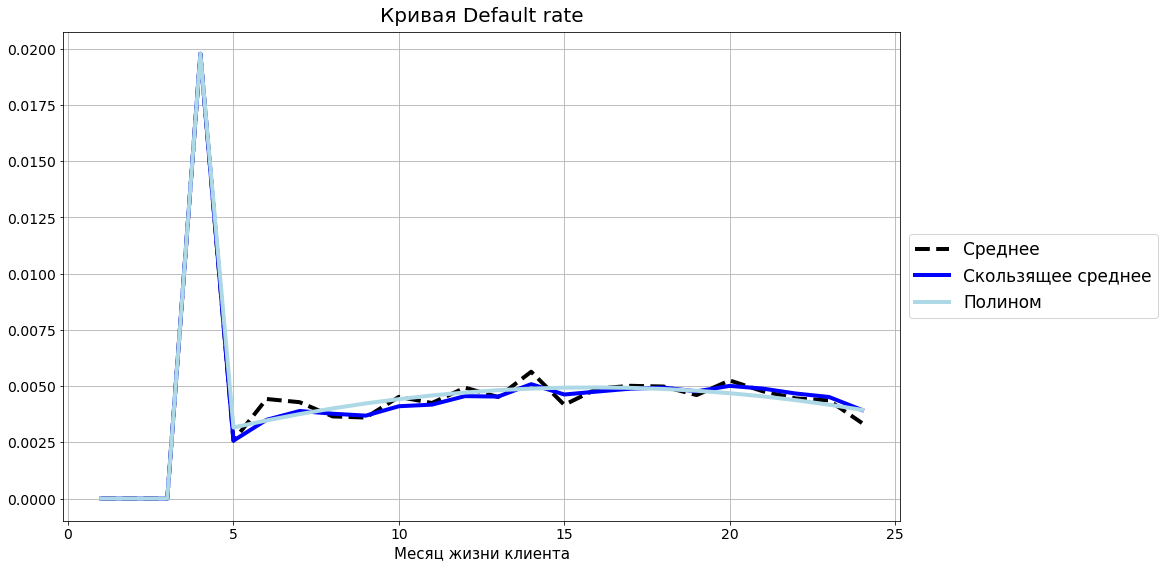

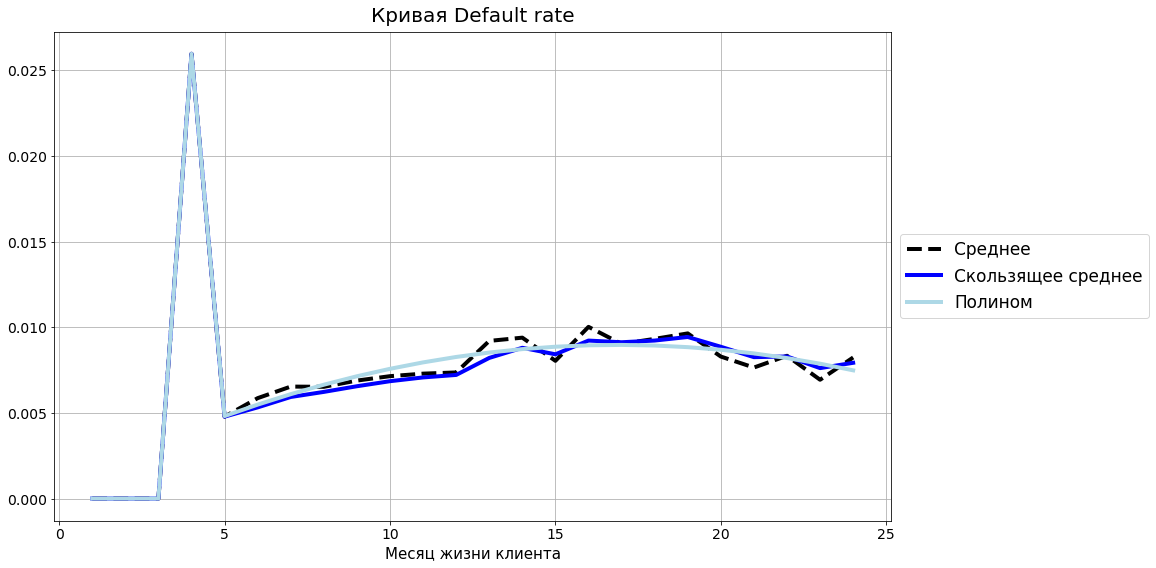

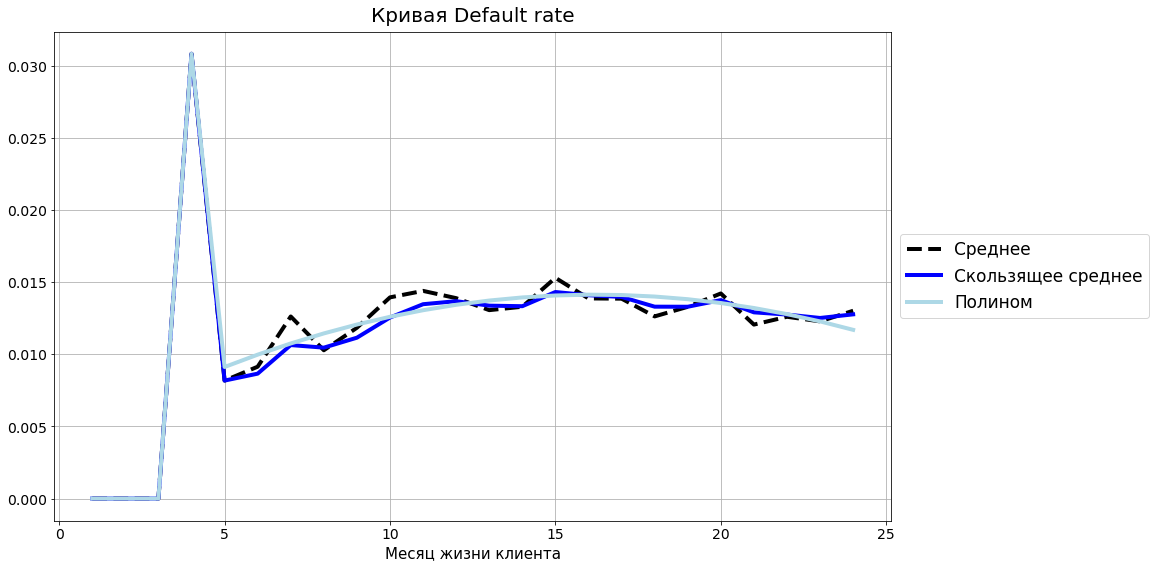

In [8]:
for i in range(3):
    df_bucket = default_rate_mean.query(f'pd_bucket == {i}').reset_index().set_index(['statement_num'])
    df_polynom = polynom_approximation(df_bucket, 5,24,2)
    df_smooth = exponential_smoothing(df_bucket, 5,24,0.5)
    # Строим получившиеся графики вместе
    plt.figure(figsize=(15, 9))
    df_polynom['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
    df_smooth['Скользящее среднее'].plot(grid=True, color = 'Blue', linestyle = '-', lw = 4)
    df_polynom['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)

    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая Default rate", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

Полином подходит лучше, так как не подстраивается под выбросы, как скользящее среднее

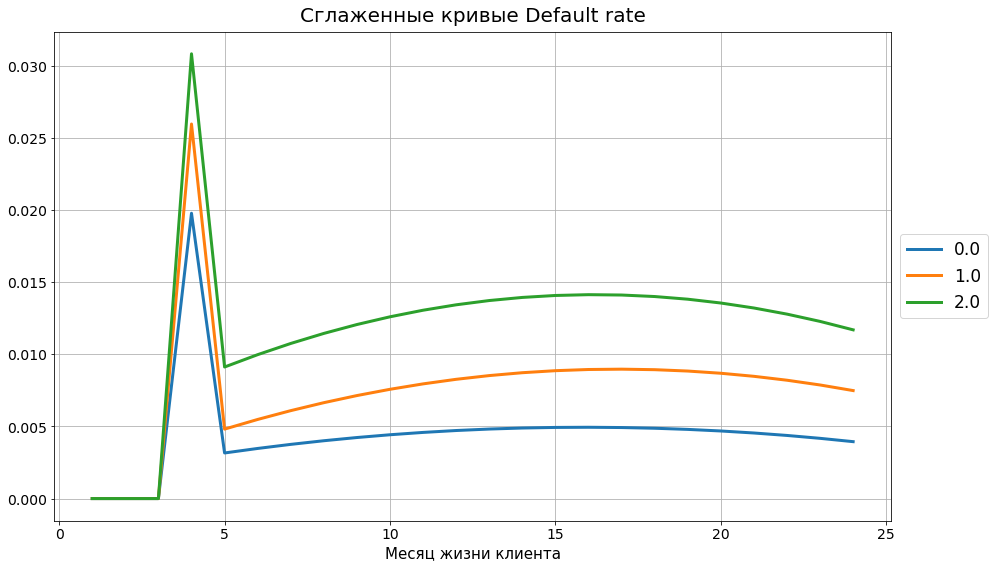

In [9]:
# Запоминаем набор бакетов и заводим пустой датафрейм под результат

buckets = df['pd_bucket'].drop_duplicates().sort_values()
df_smooth_result = pd.DataFrame()

# Далем полиномиальное сглаживание для каждого бакета
for bucket in buckets:
    df_temp = default_rate_mean.query('pd_bucket == ' + str(bucket)).reset_index().set_index(['statement_num'])
    df_smooth_result[str(bucket)] = polynom_approximation(df_temp, 5,24,2)['Полином']
    
# Строим итоговый график
df_smooth_result.plot(figsize=(15, 9), grid=True, lw = 3)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Сглаженные кривые Default rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

In [28]:
default_rate_mean.unstack().to_excel('default_rate_mean.xlsx', engine='xlsxwriter')

## Кривые DLQ ratio

Рассмотрим долю счетов в просрочке 1-3 ко всем активным счетам (активными называем счета находящихся в просрочке 0-3)
### $$DLQ ratio_n = \frac{\#DLQ_n}{\#ACT_n}$$

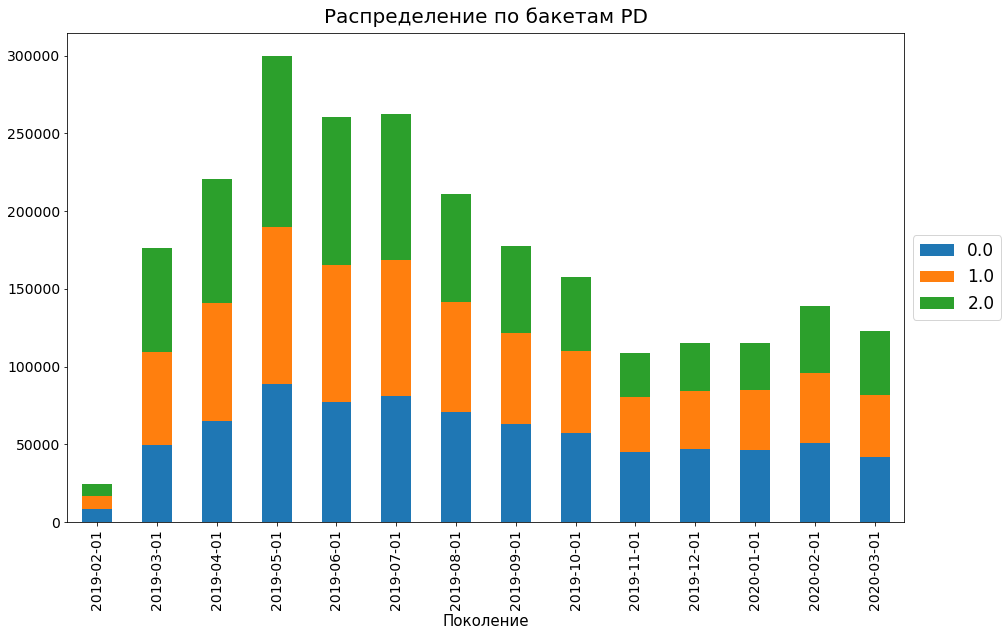

In [19]:
def plot_distribution(df, bucket):
    return pd.pivot_table(df, index=[bucket], columns='gen_month_dt',          # делаем сводную таблицу и транспонируем ее
                values="user_id",
                aggfunc=np.count_nonzero, fill_value=0)\
               .T\
               .plot(kind='bar', stacked=True, figsize=(15, 9))                    # Рисуем график распределения столбиками

plot_distribution(df, 'pd_bucket')

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Распределение по бакетам PD", size=20, verticalalignment='bottom')
plt.xlabel("Поколение", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

В феврале 2019 года слишком мало данных для анализа, поэтому выкинем его из рассмотрения

#### Рассматриваем винтажи в разбивке по бакетам

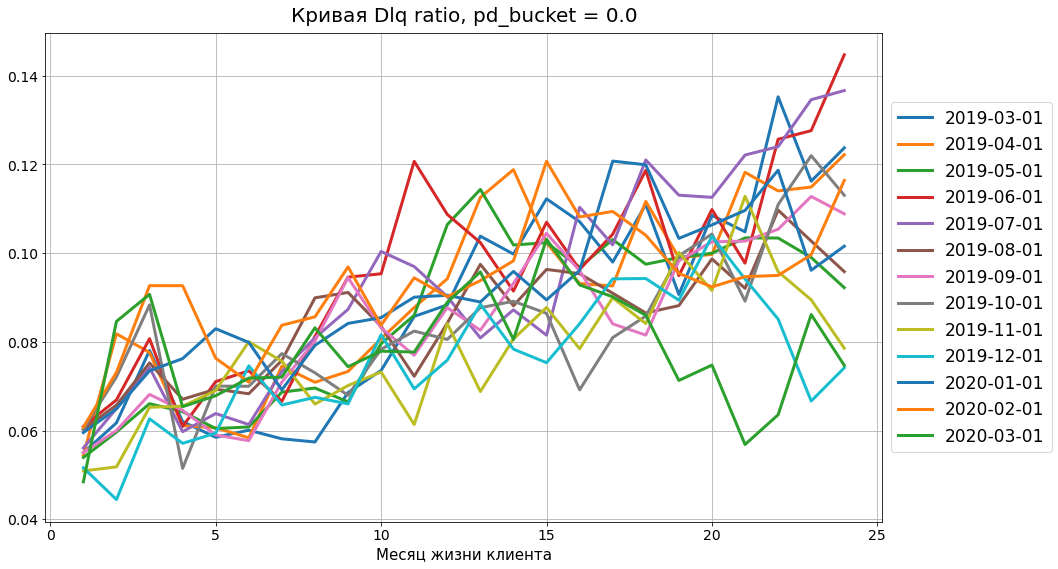

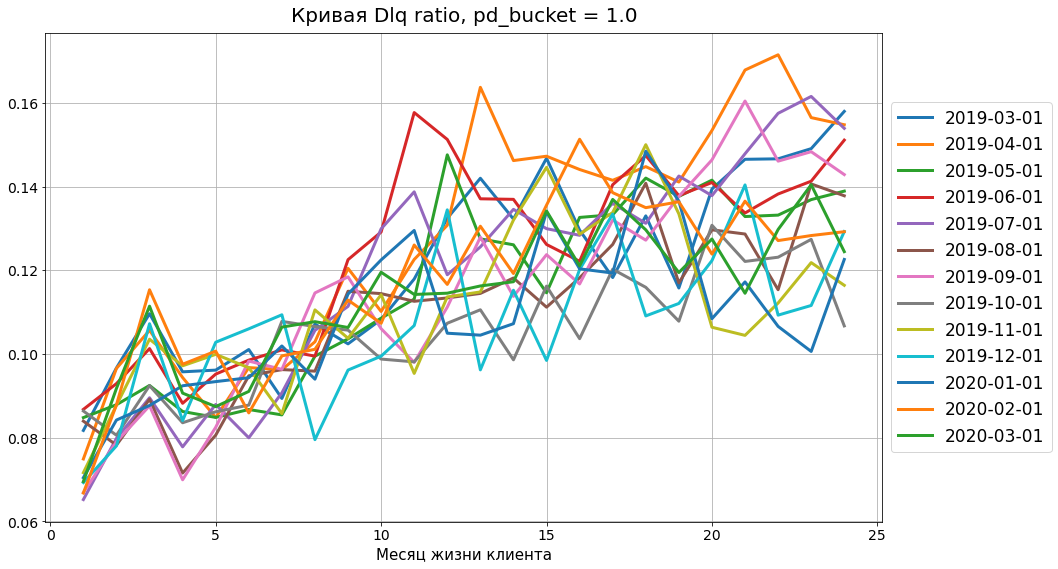

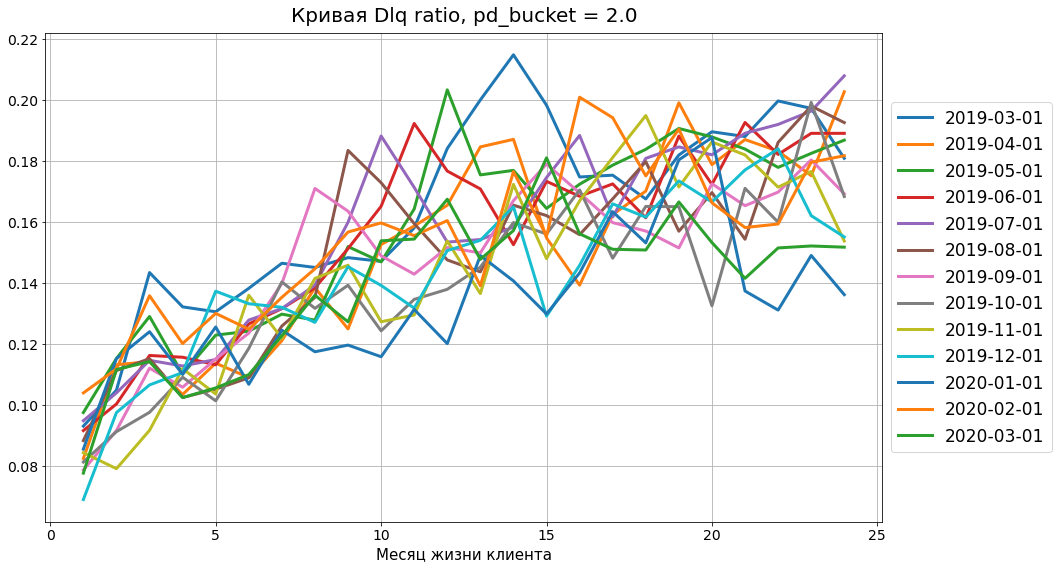

In [20]:
# Исключаем плохое поколение

exception_query = ''' ~((gen_month_dt == '2019-02-01')) '''
df.query(exception_query, inplace = True)

# Делаем список бакетов

buckets = df['pd_bucket'].drop_duplicates().sort_values(ascending = True)


# Строим график, который зависит от бакета

def plot_dlq_ratio_by_generation(data, pd_bucket):
    data_tmp = data.query(''' pd_bucket == @pd_bucket''')\
        .groupby(["gen_month_dt", "statement_num"])\
        .agg({"dlq_flg":np.sum, "act_flg":np.sum, "user_id":np.count_nonzero})\
        .rename(columns = ({"dlq_flg":'dlq_cnt', "act_flg":'act_cnt', "user_id":"cnt"}))\
        .eval('dlq_ratio = dlq_cnt / act_cnt', inplace=False)\
        .unstack('gen_month_dt')['dlq_ratio']\
        .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая Dlq ratio, pd_bucket = " + str(pd_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

    
for i in buckets:
    plot_dlq_ratio_by_generation(df, i)



Есть особая точка - 4 месяц жизни клиента. Ее особенность заключается в том, что на 4ый месяц, если клиент не платил по кредиту, он выходит в дефолт и больше у него нет статуса DLQ => значение DLQ ratio уменьшится, так как какое-то количество людей уйдет в дефолт. В таком случае сглаживать будем после 4ой точки

Усредняем временные ряды по каждому поколению

In [21]:
dlq_ratio_data = df.groupby(["gen_month_dt", "statement_num", "pd_bucket"])\
        .agg({"dlq_flg":np.sum, "act_flg":np.sum, "user_id":np.count_nonzero})\
        .rename(columns = ({"dlq_flg":'dlq_cnt', "act_flg":'act_cnt', "user_id":"cnt"}))\
        .eval('dlq_ratio = dlq_cnt / act_cnt', inplace=False)

In [22]:
dlq_ratio_data_mean = dlq_ratio_data.groupby(['statement_num', 'pd_bucket'])\
    .agg({'dlq_ratio':np.mean})\
    .rename(columns = {'dlq_ratio':'Среднее'})

In [23]:
def plot_dlq_ratio_mean(pd_bucket):
    vintages_graph = dlq_ratio_data.query('pd_bucket == ' + str(pd_bucket))\
            .unstack('gen_month_dt')\
            ['dlq_ratio']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)                                             # график винтажей
    (dlq_ratio_data_mean.query('pd_bucket == ' + str(pd_bucket))
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))  # Подаем график винтажей в ось другого,
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')                                 # чтобы отобразить их вместе
    plt.title("Кривая DLQ ratio, pd_bucket = " + str(pd_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

vintages_graph = interactive(plot_dlq_ratio_mean, pd_bucket = buckets)
vintages_graph

interactive(children=(Dropdown(description='pd_bucket', options=(0.0, 1.0, 2.0), value=0.0), Output()), _dom_c…

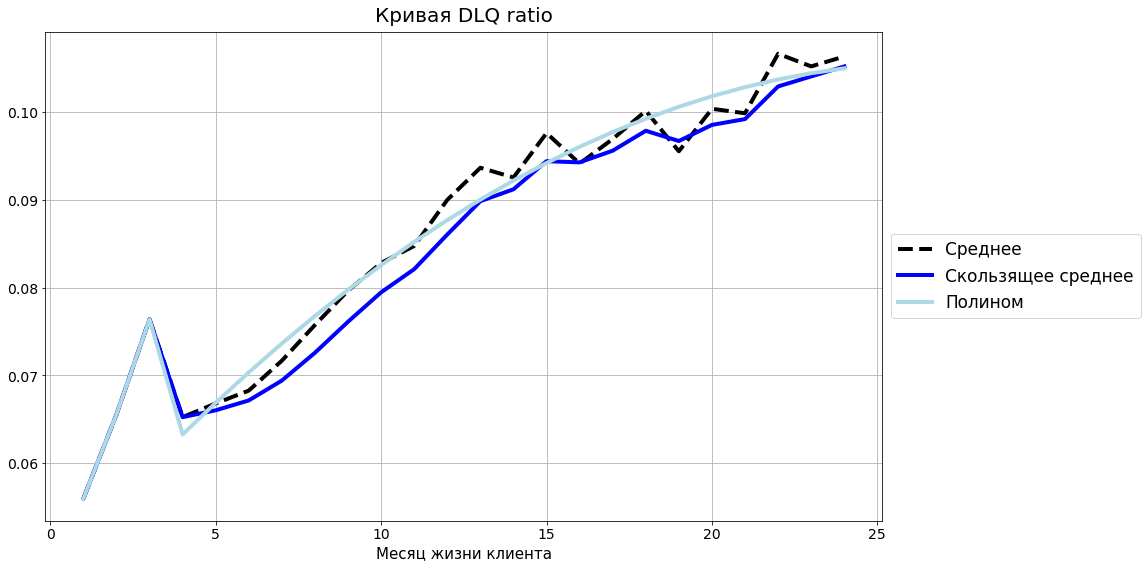

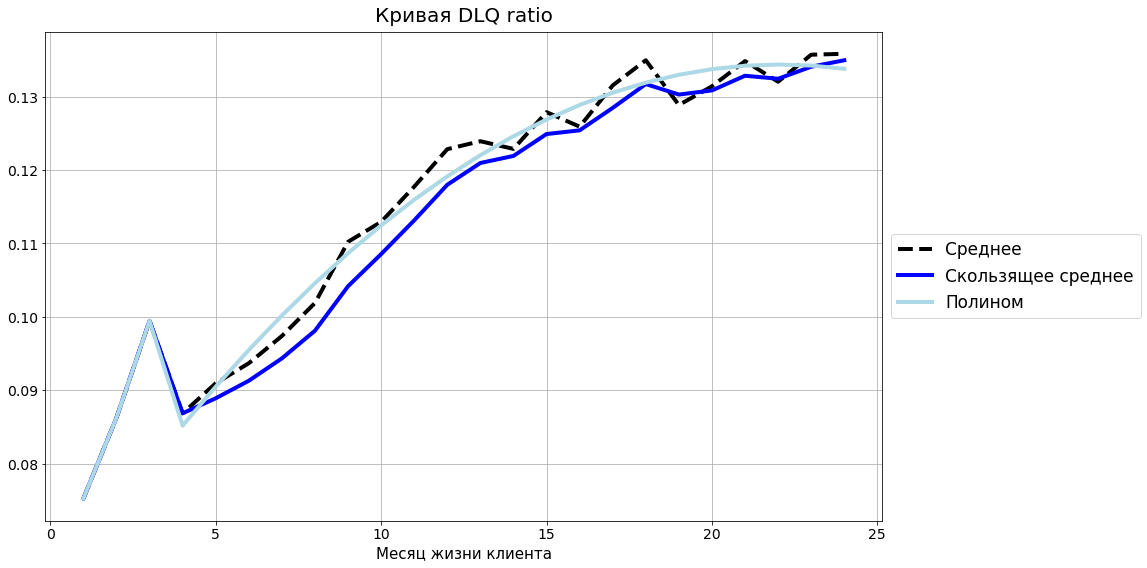

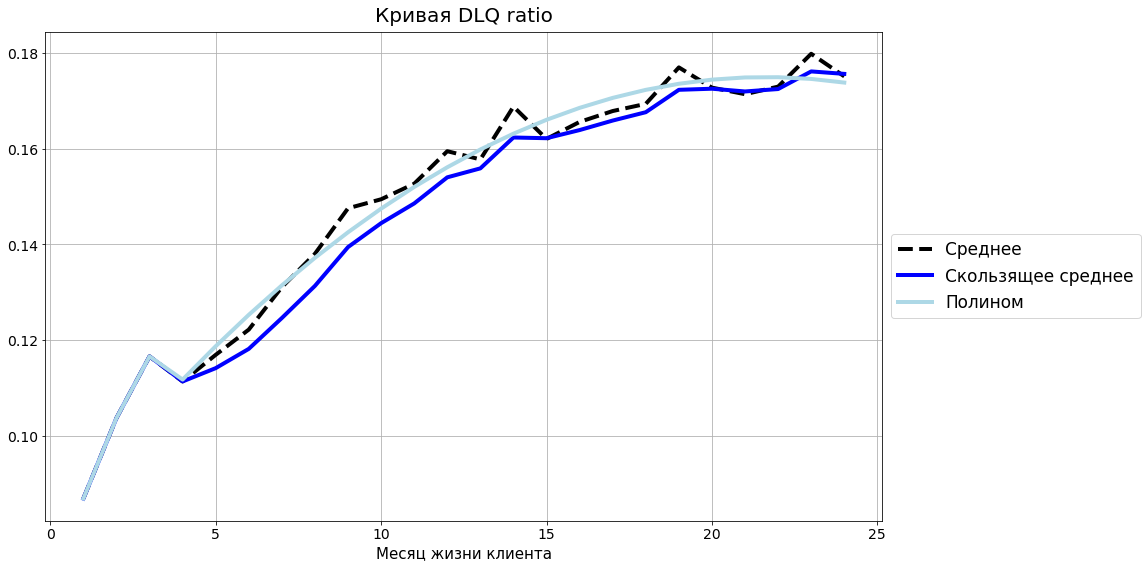

In [24]:
for i in range(3):
    df_bucket = dlq_ratio_data_mean.query(f'pd_bucket == {i}').reset_index().set_index(['statement_num'])
    df_polynom = polynom_approximation(df_bucket, 4,24,2)
    df_smooth = exponential_smoothing(df_bucket, 4,24,0.5)
    # Строим получившиеся графики вместе
    plt.figure(figsize=(15, 9))
    df_polynom['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
    df_smooth['Скользящее среднее'].plot(grid=True, color = 'Blue', linestyle = '-', lw = 4)
    df_polynom['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)

    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая DLQ ratio", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

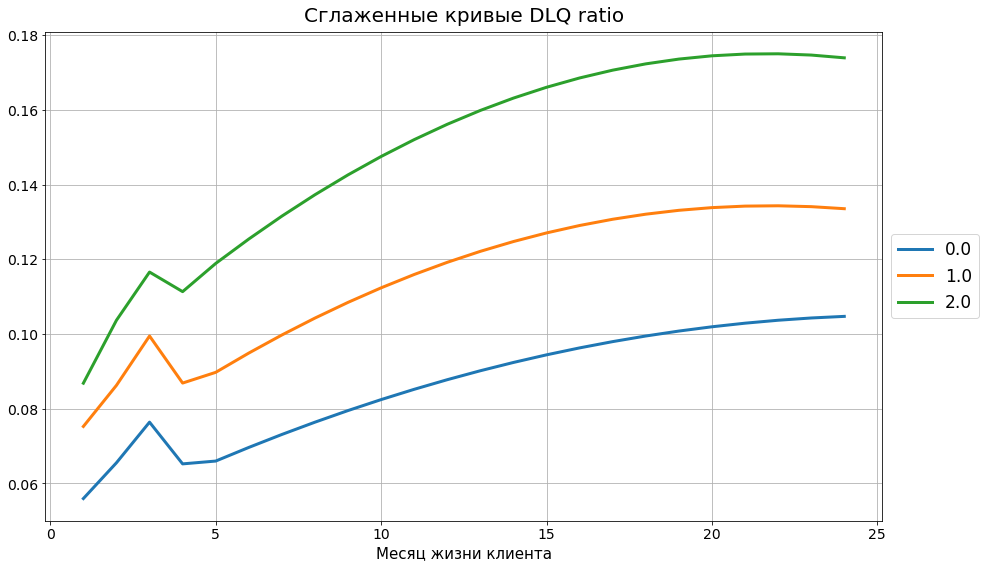

In [25]:
# Запоминаем набор бакетов и заводим пустой датафрейм под результат

buckets = df['pd_bucket'].drop_duplicates().sort_values()
df_smooth_result = pd.DataFrame()

# Далем полиномиальное сглаживание для каждого бакета
for bucket in buckets:
    df_temp = dlq_ratio_data_mean.query('pd_bucket == ' + str(bucket)).reset_index().set_index(['statement_num'])
    df_smooth_result[str(bucket)] = polynom_approximation(df_temp, 5,24,2)['Полином']
    
# Строим итоговый график
df_smooth_result.plot(figsize=(15, 9), grid=True, lw = 3)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Сглаженные кривые DLQ ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

In [29]:
dlq_ratio_data_mean.unstack().to_excel('clo_ratio_mean.xlsx', engine='xlsxwriter')

In [30]:
dlq_ratio_data_mean.unstack()

Среднее                    
pd_bucket           0.0       1.0       2.0
statement_num                              
1              0.055950  0.075253  0.086833
2              0.065532  0.086257  0.103675
3              0.076402  0.099463  0.116576
4              0.065234  0.086868  0.111339
5              0.066800  0.090954  0.116907
6              0.068264  0.093687  0.122187
7              0.071676  0.097392  0.131069
8              0.075748  0.101889  0.138056
9              0.079659  0.110224  0.147570
10             0.082817  0.112938  0.149455
11             0.084759  0.117740  0.152704
12             0.090013  0.122847  0.159511
13             0.093677  0.123928  0.157794
14             0.092568  0.122882  0.168838
15             0.097632  0.127888  0.162080
16             0.094159  0.125911  0.165637
17             0.096955  0.131529  0.167915
18             0.100166  0.134956  0.169416
19             0.095557  0.128857  0.177042
20             0.100403  0.131412  0.172812
21             0.099892  0.134842  0.171437
22             0.106672  0.132030  0.173023
23             0.105236  0.135714  0.179891
24             0.106368  0.135836  0.175172